# Fourier

In [1]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt

**Carregar imagens**

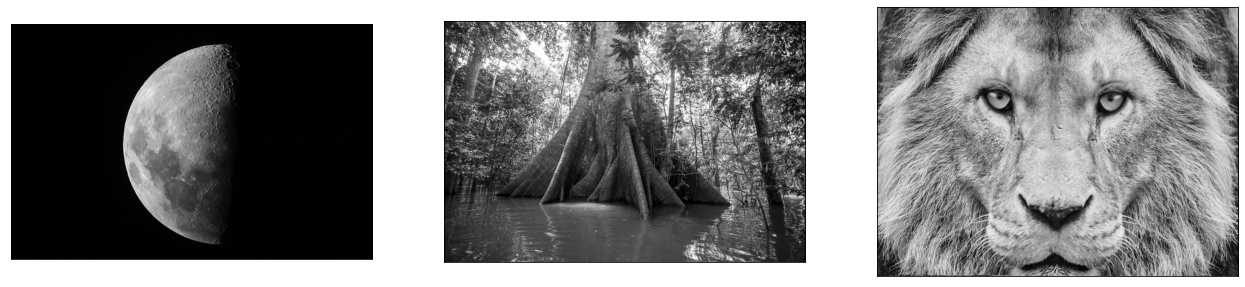

In [2]:
images = []

images.append(cv2.imread('images/moon.jpg', 0))
images.append(cv2.imread('images/tree.jpg', 0))
images.append(cv2.imread('images/lion.jpg', 0))

plt.figure(figsize=(22,6))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

https://docs.opencv.org/4.x/de/dbc/tutorial_py_fourier_transform.html

**Fourier transform in Numpy**

In [3]:
def fft_numpy(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))

    plt.figure(figsize=(12, 4))
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

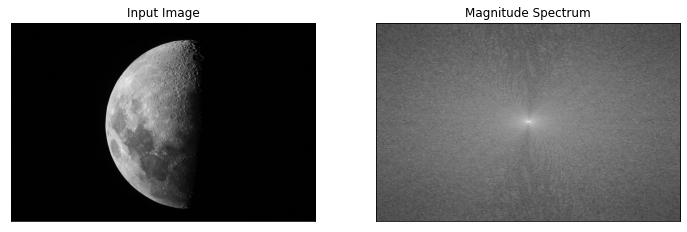

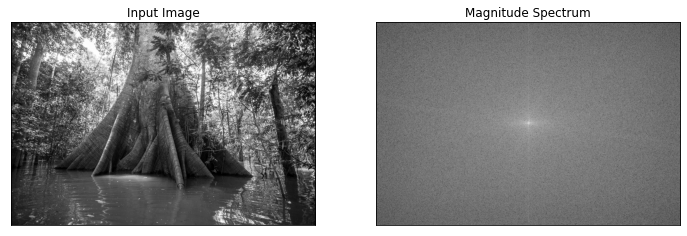

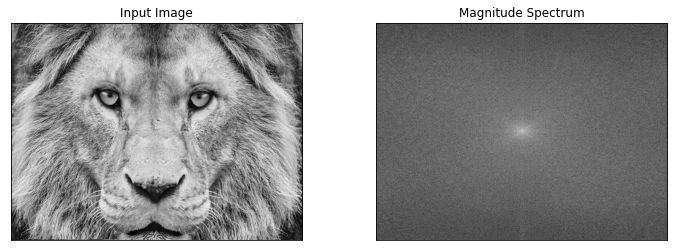

In [4]:
for image in images:
    fft_numpy(image)

In [5]:
def ifft_numpy(img):
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift[crow-30:crow+31, ccol-30:ccol+31] = 0
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.real(img_back)

    plt.figure(figsize=(18, 4))
    plt.subplot(131), plt.imshow(img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(img_back, cmap='gray')
    plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(img_back)
    plt.title('Result in JET'), plt.xticks([]), plt.yticks([])
    plt.show()

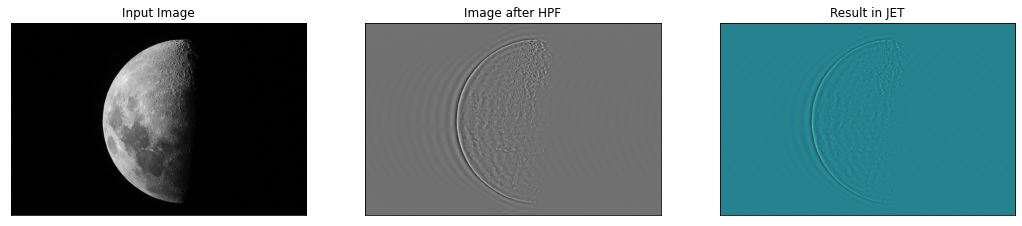

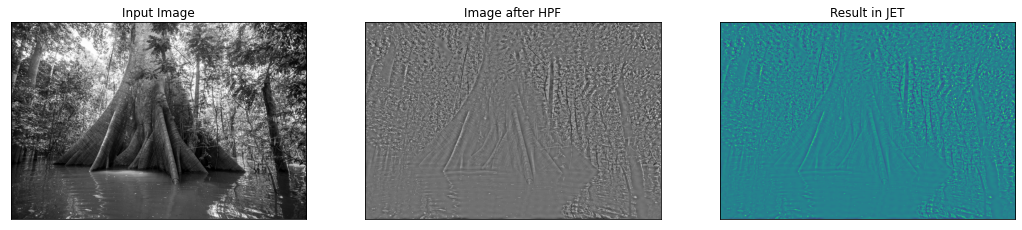

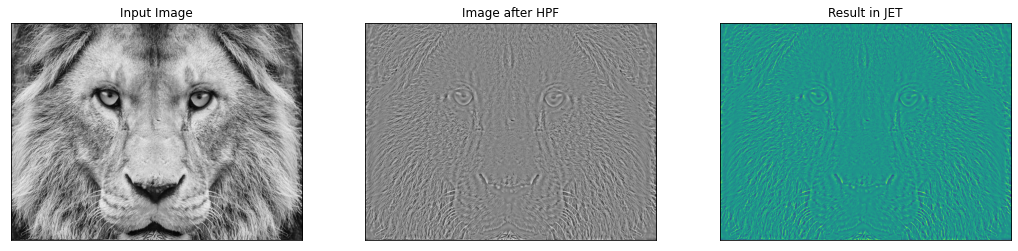

In [6]:
for image in images:
    ifft_numpy(image)

**Fourier transform in OpenCV**

In [7]:
def dft_opencv(img):
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * \
        np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
        
    plt.figure(figsize=(12, 4))
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

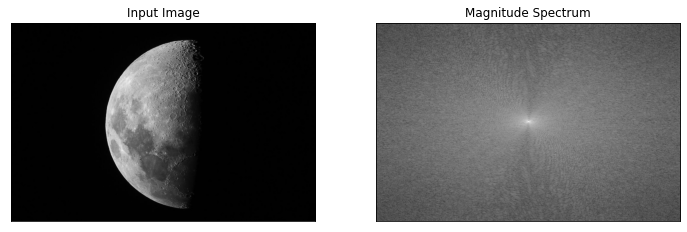

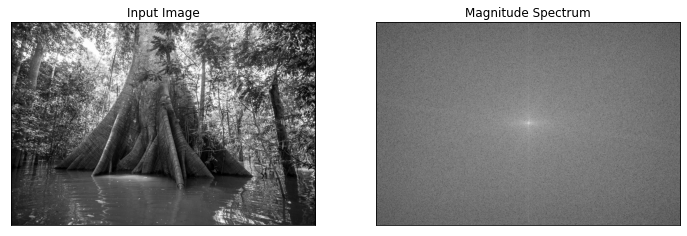

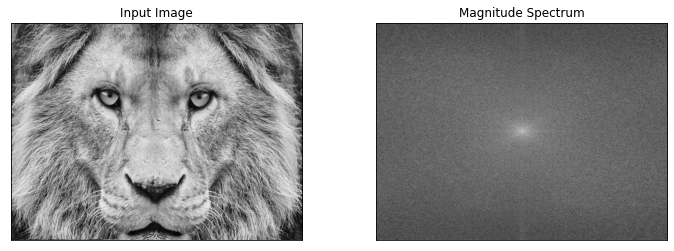

In [8]:
for image in images:
    dft_opencv(image)

In [9]:
def idft_opencv(img):
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1
    
    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img_back, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

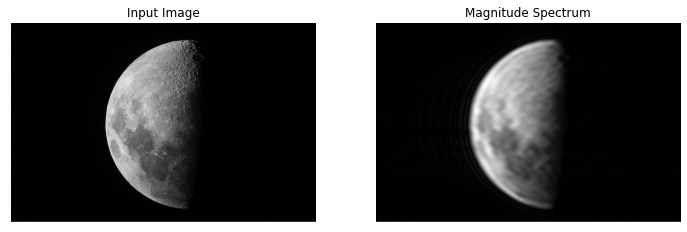

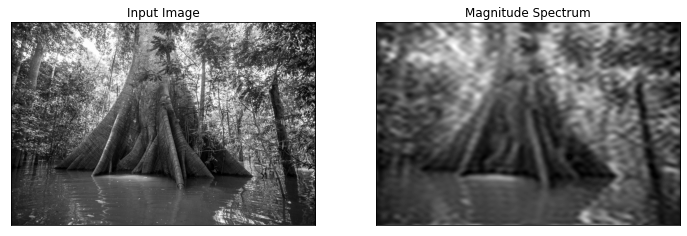

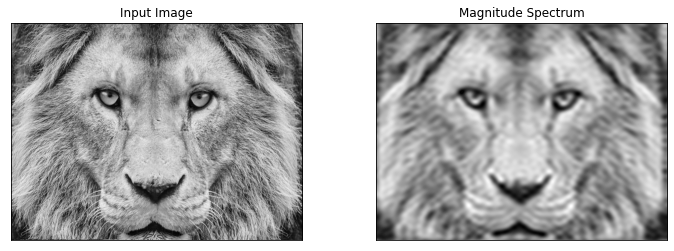

In [10]:
for image in images:
    idft_opencv(image)

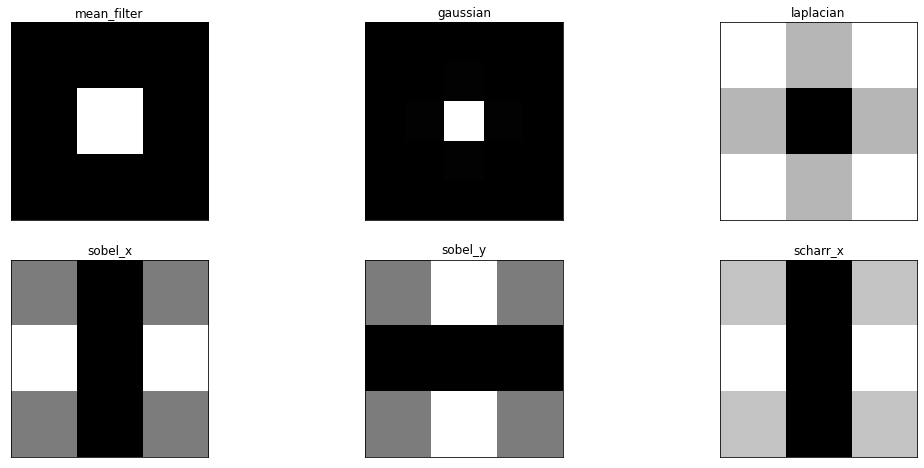

In [11]:
# simple averaging filter without scaling parameter
mean_filter = np.ones((3, 3))
# creating a gaussian filter
x = cv2.getGaussianKernel(5, 10)
gaussian = x*x.T
# different edge detecting filters scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10, 0, 10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian = np.array([[0, 1, 0],
                      [1, -4, 1],
                      [0, 1, 0]])
filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian', 'laplacian', 'sobel_x',
               'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

plt.figure(figsize=(18, 8))
for i in range(6):
    plt.subplot(2, 3, i+1), plt.imshow(mag_spectrum[i], cmap='gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

https://pyimagesearch.com/2020/06/15/opencv-fast-fourier-transform-fft-for-blur-detection-in-images-and-video-streams/

In [12]:
def detect_blur_fft(image, flags):
    
	size = flags[0]
	thresh = flags[1]
	vis = flags[2]
	channels = flags[3]

	# grab the dimensions of the image and use the dimensions to
	# derive the center (x, y)-coordinates
	(h, w) = image.shape
	(cX, cY) = (int(w / 2.0), int(h / 2.0))

	# compute the FFT to find the frequency transform, then shift
	# the zero frequency component (i.e., DC component located at
	# the top-left corner) to the center where it will be more
	# easy to analyze
	fft = np.fft.fft2(image)
	fftShift = np.fft.fftshift(fft)

	# check to see if we are visualizing our output
	if vis:
		# compute the magnitude spectrum of the transform
		magnitude = 20 * np.log(np.abs(fftShift))
		# display the original input image
		(fig, ax) = plt.subplots(1, 2, )
		ax[0].imshow(image, cmap="gray")
		ax[0].set_title("Input")
		ax[0].set_xticks([])
		ax[0].set_yticks([])
		# display the magnitude image
		ax[1].imshow(magnitude, cmap="gray")
		ax[1].set_title("Magnitude Spectrum")
		ax[1].set_xticks([])
		ax[1].set_yticks([])
		# show our plots
		plt.show()

	# zero-out the center of the FFT shift (i.e., remove low
	# frequencies), apply the inverse shift such that the DC
	# component once again becomes the top-left, and then apply
	# the inverse FFT
	fftShift[cY - size:cY + size, cX - size:cX + size] = 0
	fftShift = np.fft.ifftshift(fftShift)
	recon = np.fft.ifft2(fftShift)

	# compute the magnitude spectrum of the reconstructed image,
	# then compute the mean of the magnitude values
	magnitude = 20 * np.log(np.abs(recon))
	mean = np.mean(magnitude)
	# the image will be considered "blurry" if the mean value of the
	# magnitudes is less than the threshold value
	return (mean, mean <= thresh)

In [13]:
def detect_blur_image(orig, flags):
    
    test = flags[4]
    
    orig = imutils.resize(orig, width=500)
    gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    (mean, blurry) = detect_blur_fft(gray, flags)

    image = np.dstack([gray] * 3)
    color = (0, 0, 255) if blurry else (0, 255, 0)
    text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
    text = text.format(mean)
    cv2.putText(image, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                color, 2)
    print("[INFO] {}".format(text))
    plt.imshow(image)
    plt.title("Output")
    plt.show()

    if test > 0:
        for radius in range(1, 6, 2):
            image = gray.copy()
            if radius > 0:
                image = cv2.GaussianBlur(image, (radius, radius), 0)
                (mean, blurry) = detect_blur_fft(image, flags)
                image = np.dstack([image] * 3)
                color = (0, 0, 255) if blurry else (0, 255, 0)
                text = "Blurry ({:.4f})" if blurry else "Not Blurry ({:.4f})"
                text = text.format(mean)
                cv2.putText(image, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
                            0.7, color, 2)
                print("[INFO] Kernel: {}, Result: {}".format(radius, text))
            plt.imshow(image)
            plt.title("Test image")
            plt.show()

[INFO] Blurry (-10.6547)


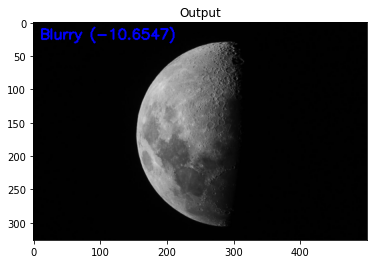

[INFO] Kernel: 1, Result: Blurry (-10.6547)


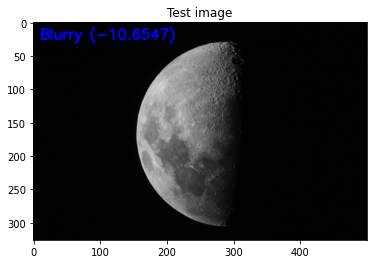

[INFO] Kernel: 3, Result: Blurry (-16.6862)


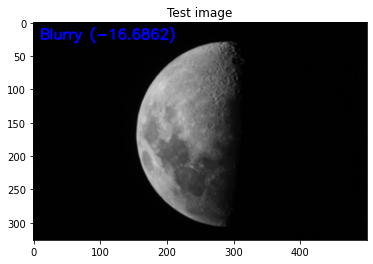

[INFO] Kernel: 5, Result: Blurry (-22.5717)


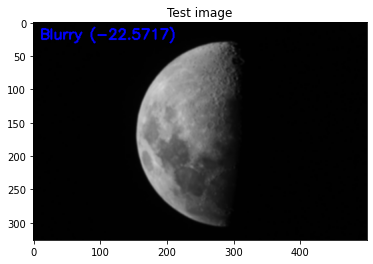

[INFO] Not Blurry (40.6272)


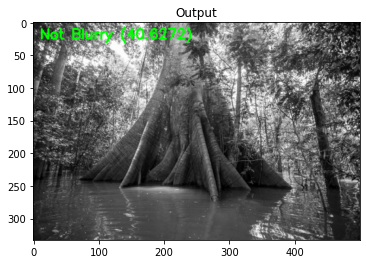

[INFO] Kernel: 1, Result: Not Blurry (40.6272)


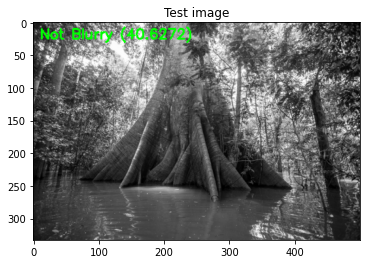

[INFO] Kernel: 3, Result: Not Blurry (29.0442)


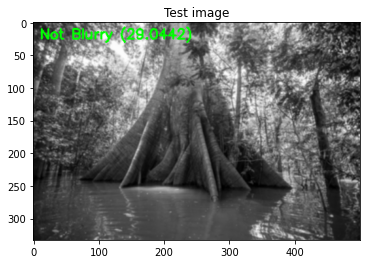

[INFO] Kernel: 5, Result: Not Blurry (21.8315)


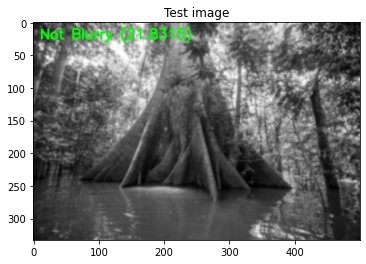

[INFO] Not Blurry (40.8918)


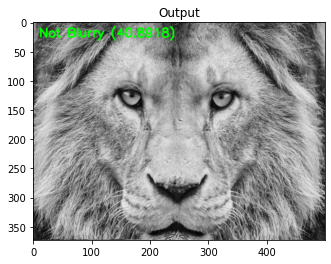

[INFO] Kernel: 1, Result: Not Blurry (40.8918)


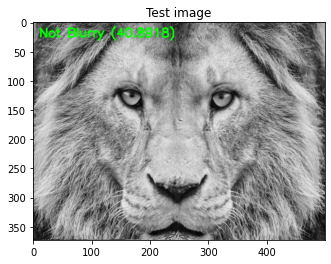

[INFO] Kernel: 3, Result: Not Blurry (28.6271)


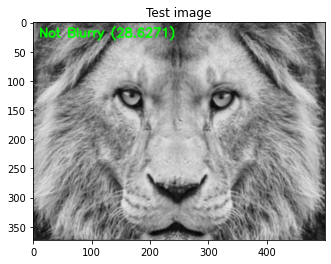

[INFO] Kernel: 5, Result: Not Blurry (20.9574)


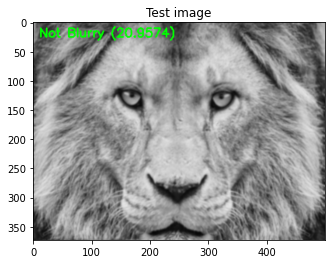

In [14]:
flags = [60, 10, False, 3, 1]
images = []

images.append(cv2.imread('images/moon.jpg'))
images.append(cv2.imread('images/tree.jpg'))
images.append(cv2.imread('images/lion.jpg'))

for image in images:
    detect_blur_image(image, flags)